In [9]:
pip install pandas scikit-learn xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


1. Feature Engineering (new features like BMI_Category, Age_Group)
2. Label Encoding for categorical variables
3. Standard Scaling of features
4. SMOTE (oversampling the minority class)
5. Hyperparameter Tuning with GridSearchCV (Random Forest)
6. Using class_weight and scale_pos_weight for imbalance handling
7. Training two models (Random Forest and XGBoost)
8. Model Evaluation (ROC AUC, classification report, confusion matrix)
9. Feature Importance analysis (Random Forest)

In [22]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# Step 2: Load the data
df = pd.read_csv('personalized_medication_dataset.csv')

# Step 3: Create target variable (Hypertension as target)
df['HBP'] = df['Chronic_Conditions'].apply(lambda x: 1 if 'Hypertension' in str(x) else 0)

# Step 4: Feature Engineering (Add new features)
def bmi_category(bmi):
    if bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal'
    elif bmi < 30: return 'Overweight'
    else: return 'Obese'

def age_group(age):
    if age < 30: return 'Young'
    elif age < 60: return 'Middle-aged'
    else: return 'Senior'

df['BMI_Category'] = df['BMI'].apply(bmi_category)
df['Age_Group'] = df['Age'].apply(age_group)

# Step 5: Select features
features = ['Age', 'Gender', 'Weight_kg', 'Height_cm', 'BMI', 'Genetic_Disorders', 'BMI_Category', 'Age_Group']
X = df[features].copy()
y = df['HBP']

# Step 6: Encode categorical features
categorical_cols = ['Gender', 'Genetic_Disorders', 'BMI_Category', 'Age_Group']
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 8: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 10: Hyperparameter tuning using GridSearchCV (Random Forest)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Step 11: Train Random Forest with GridSearchCV
grid_search_rf.fit(X_train_resampled, y_train_resampled)
best_rf = grid_search_rf.best_estimator_

# Step 12: Evaluate Random Forest
y_pred_rf_probs = best_rf.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_probs)

print("Random Forest ROC AUC:", roc_auc_rf)
print("Random Forest Classification Report:\n", classification_report(y_test, best_rf.predict(X_test_scaled)))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, best_rf.predict(X_test_scaled)))

# Step 13: Train XGBoost Classifier
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Step 14: Evaluate XGBoost
y_pred_xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_probs)

print("XGBoost ROC AUC:", roc_auc_xgb)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_model.predict(X_test_scaled)))

# Step 15: Feature Importance (Random Forest)
importances = best_rf.feature_importances_
feature_names = X.columns

print("\nFeature Importances (Random Forest):")
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance:.4f}")

Random Forest ROC AUC: 0.5086666666666666
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77       150
           1       0.19      0.14      0.16        50

    accuracy                           0.64       200
   macro avg       0.46      0.47      0.46       200
weighted avg       0.60      0.64      0.62       200

Random Forest Confusion Matrix:
 [[120  30]
 [ 43   7]]
XGBoost ROC AUC: 0.45920000000000005
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69       150
           1       0.25      0.36      0.30        50

    accuracy                           0.57       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.62      0.57      0.59       200


Feature Importances (Random Forest):
Age: 0.1858
Height_cm: 0.1850
Weight_kg: 0.1797
BMI: 0.1722
Genetic_Disorders: 0.1001
Gender: 0.0837
BM

PREDICTION WITH FEATURE IMPORTANCE GRAPH SHAP VLAUE

Random Forest ROC AUC: 0.5086666666666666
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77       150
           1       0.19      0.14      0.16        50

    accuracy                           0.64       200
   macro avg       0.46      0.47      0.46       200
weighted avg       0.60      0.64      0.62       200

Random Forest Confusion Matrix:
 [[120  30]
 [ 43   7]]
XGBoost ROC AUC: 0.45920000000000005
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69       150
           1       0.25      0.36      0.30        50

    accuracy                           0.57       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.62      0.57      0.59       200


Feature Importances (Random Forest):
Age: 0.1858
Height_cm: 0.1850
Weight_kg: 0.1797
BMI: 0.1722
Genetic_Disorders: 0.1001
Gender: 0.0837
BM

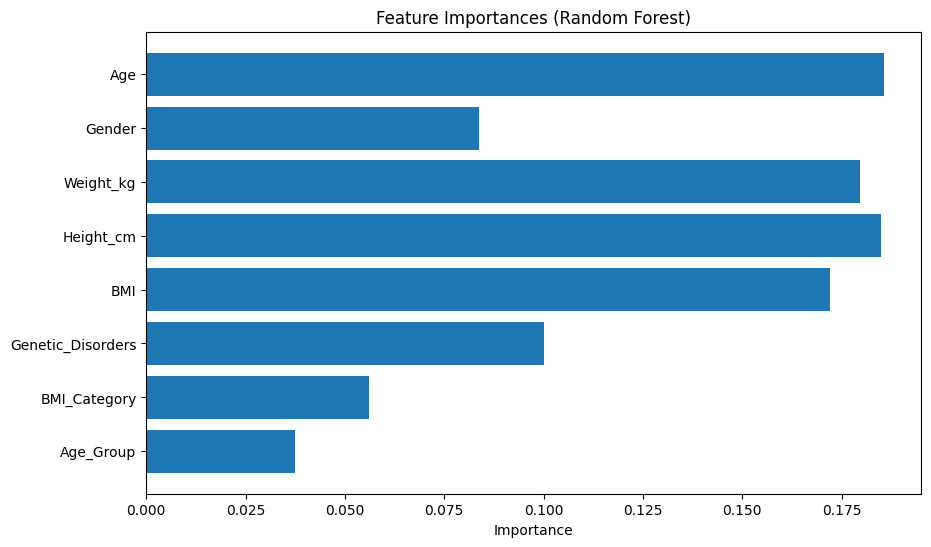

<Figure size 640x480 with 0 Axes>

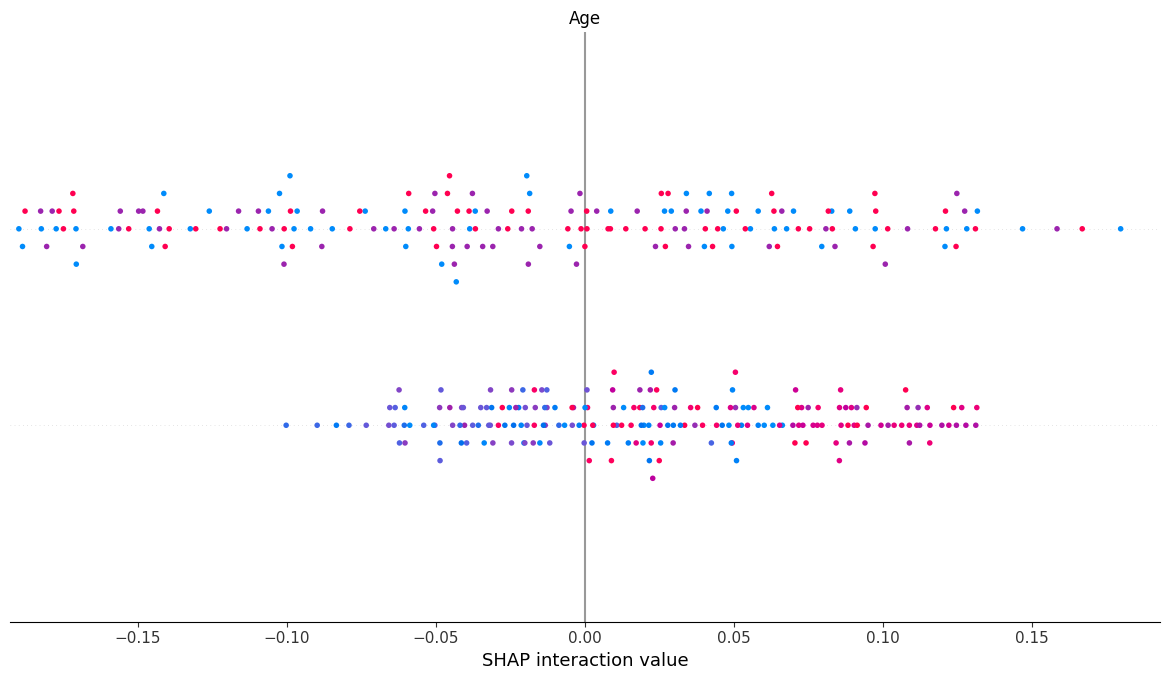

In [21]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# Step 2: Load the data
df = pd.read_csv('personalized_medication_dataset.csv')

# Step 3: Create target variable (Hypertension as target)
df['HBP'] = df['Chronic_Conditions'].apply(lambda x: 1 if 'Hypertension' in str(x) else 0)

# Step 4: Feature Engineering (Add new features)
def bmi_category(bmi):
    if bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal'
    elif bmi < 30: return 'Overweight'
    else: return 'Obese'

def age_group(age):
    if age < 30: return 'Young'
    elif age < 60: return 'Middle-aged'
    else: return 'Senior'

df['BMI_Category'] = df['BMI'].apply(bmi_category)
df['Age_Group'] = df['Age'].apply(age_group)

# Step 5: Select features
features = ['Age', 'Gender', 'Weight_kg', 'Height_cm', 'BMI', 'Genetic_Disorders', 'BMI_Category', 'Age_Group']
X = df[features].copy()
y = df['HBP']

# Step 6: Encode categorical features
categorical_cols = ['Gender', 'Genetic_Disorders', 'BMI_Category', 'Age_Group']
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 8: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 10: Hyperparameter tuning using GridSearchCV (Random Forest)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Step 11: Train Random Forest with GridSearchCV
grid_search_rf.fit(X_train_resampled, y_train_resampled)
best_rf = grid_search_rf.best_estimator_

# Step 12: Evaluate Random Forest
y_pred_rf_probs = best_rf.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_probs)

print("Random Forest ROC AUC:", roc_auc_rf)
print("Random Forest Classification Report:\n", classification_report(y_test, best_rf.predict(X_test_scaled)))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, best_rf.predict(X_test_scaled)))

# Step 13: Train XGBoost Classifier
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Step 14: Evaluate XGBoost
y_pred_xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_probs)

print("XGBoost ROC AUC:", roc_auc_xgb)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_model.predict(X_test_scaled)))

# Step 15: Feature Importance (Random Forest)
importances = best_rf.feature_importances_
feature_names = X.columns

print("\nFeature Importances (Random Forest):")
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance:.4f}")

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

# Step 16: Explainable AI (SHAP) - For Random Forest
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_scaled_df)

# Check if it's list (multi-class case)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# SHAP summary plot (bar plot only)
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar")
plt.show()  # Ensure plot shows properly

# OPTIONAL: If you want beeswarm plot also (comment out if you don't want)
# shap.summary_plot(shap_values, X_test_scaled_df)
# plt.show()

